In [12]:
import os
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F

# --- Helper: convert PIL -> torch tensor [C,H,W] ---
def pil_to_tensor(img):
    arr = np.array(img).astype(np.float32) / 255.0
    arr = torch.from_numpy(arr).permute(2, 0, 1)  # [C,H,W]
    return arr

# --- Frequency error computation ---
def frequency_errors(orig, pred, kernel_size=15, sigma=3):
    """
    orig, pred: [C,H,W] torch tensors in [0,1]
    """
    if orig.shape != pred.shape:
        raise ValueError(f"Shape mismatch: {orig.shape} vs {pred.shape}")

    orig = orig.unsqueeze(0)  # [1,C,H,W]
    pred = pred.unsqueeze(0)

    # Gaussian blur kernel
    x = torch.arange(-kernel_size//2 + 1., kernel_size//2 + 1.)
    x_grid = x.repeat(kernel_size).view(kernel_size, kernel_size)
    y_grid = x_grid.t()
    gaussian_kernel = torch.exp(-(x_grid**2 + y_grid**2) / (2 * sigma**2))
    gaussian_kernel = gaussian_kernel / gaussian_kernel.sum()
    gaussian_kernel = gaussian_kernel.view(1,1,kernel_size,kernel_size)

    # apply to each channel
    gaussian_kernel = gaussian_kernel.repeat(orig.shape[1],1,1,1)

    # low frequency parts
    orig_low = F.conv2d(orig, gaussian_kernel, padding=kernel_size//2, groups=orig.shape[1])
    pred_low = F.conv2d(pred, gaussian_kernel, padding=kernel_size//2, groups=pred.shape[1])

    # high frequency parts
    orig_high = orig - orig_low
    pred_high = pred - pred_low

    # errors
    low_err = torch.mean((orig_low - pred_low) ** 2).item()
    high_err = torch.mean((orig_high - pred_high) ** 2).item()

    return {"low_error": low_err, "high_error": high_err}

In [13]:
# --- Process multiple videos ---
videos = ["Beauty", "HoneyBee", "Bosphorus", "ShakeNDry"]

results = {}
for vid in videos:
    pred_path = f'benchmark_results/preds_gop2_q4/{vid}/im00002_pred.png'
    orig_path = f'data/{vid}/images/frame_0001.png'

    pred = Image.open(pred_path).convert("RGB")
    orig = Image.open(orig_path).convert("RGB")

    pred_t = pil_to_tensor(pred)
    orig_t = pil_to_tensor(orig)

    errors = frequency_errors(orig_t, pred_t)
    results[vid] = errors

# --- Print results ---
print("Frequency Errors per Video:")
for vid, err in results.items():
    print(f"{vid}: Low={err['low_error']:.6f}, High={err['high_error']:.6f}")


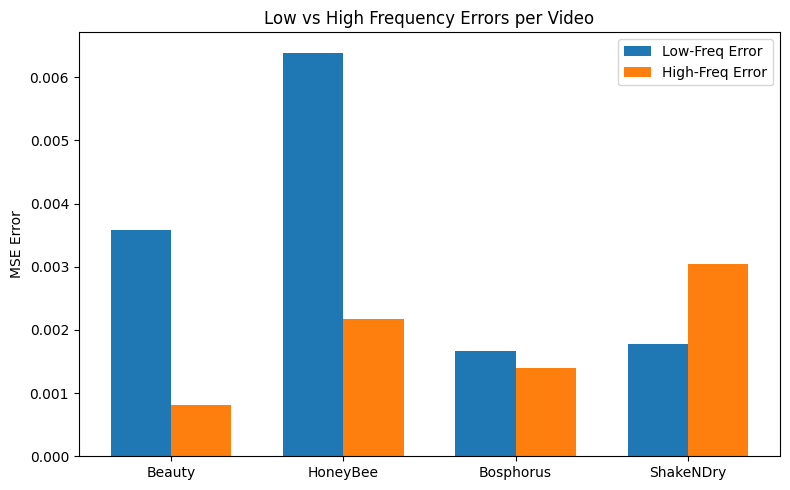

In [11]:
 # --- Bar chart ---
labels = list(results.keys())
low_vals = [results[v]["low_error"] for v in labels]
high_vals = [results[v]["high_error"] for v in labels]

x = np.arange(len(labels))  # label locations
width = 0.35

fig, ax = plt.subplots(figsize=(8,5))
rects1 = ax.bar(x - width/2, low_vals, width, label="Low-Freq Error")
rects2 = ax.bar(x + width/2, high_vals, width, label="High-Freq Error")

ax.set_ylabel("MSE Error")
ax.set_title("Low vs High Frequency Errors per Video")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.tight_layout()
# plt.show()
plt.savefig('data/error.png')

In [3]:
import torch
import torch.nn.functional as F
from softsplat import softsplat
import matplotlib.pyplot as plt
import numpy as np
from utils import load_controls_and_flows

# --- 1. Your fusion function ---
def soft_fuse(W_fwd, W_bwd, M_fwd, M_bwd, conf_fwd=None, conf_bwd=None, eps=1e-6):
    """
    W_*: [B, C, H, W] warped frames
    M_*: [B, 1, H, W] valid masks (1 valid, 0 hole)
    conf_*: [B, 1, H, W] optional confidences; if None, use masks
    """
    if conf_fwd is None: conf_fwd = M_fwd
    if conf_bwd is None: conf_bwd = M_bwd

    # normalize to sum-1 via softmax-style
    w = torch.cat([conf_fwd, conf_bwd], dim=1)  # [B, 2, H, W]
    w = torch.clamp(w, min=0)
    w_sum = w.sum(dim=1, keepdim=True) + eps
    w_norm = w / w_sum                          # [B, 2, H, W]

    out = w_norm[:, :1] * W_fwd + w_norm[:, 1:] * W_bwd
    # fill remaining holes (if both invalid) with average
    holes = (M_fwd + M_bwd) < 0.5
    if holes.any():
        avg = 0.5 * (W_fwd + W_bwd)
        out = torch.where(holes.expand_as(out), avg, out)
    return out

# --- 2. Updated display function for three images ---
def display_fusion_results(tensor1, tensor2, tensor3, main_title=""):
    """Displays three tensors: forward warp, backward warp, and fused result."""
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    tensors = [tensor1, tensor2, tensor3]
    titles = ["Forward Warp", "Backward Warp", "Fused Result"]

    for i, (tensor, title) in enumerate(zip(tensors, titles)):
        img_np = np.transpose(tensor.squeeze(0).cpu().detach().numpy(), (1, 2, 0))
        img_np = np.clip(img_np, 0, 1)
        axes[i].imshow(img_np)
        axes[i].set_title(title, fontsize=12)
        axes[i].axis('off')

    plt.suptitle(main_title, fontsize=16)
    plt.show()


In [4]:

video ='Bosphorus'
device = 'cuda' 
dtype = torch.float32
local,flow = load_controls_and_flows(
        f'data/{video}/images/frame_0000.png',
        f'data/{video}/images/frame_0004.png',
        f'data/{video}/optical_flow/optical_flow_gop_4_raft/flow_0000_0003.flo',
        f'data/{video}/optical_flow_bwd/optical_flow_gop_4_raft/flow_0004_0003.flo',
        size=(512, 512),
        device=device,
        dtype=dtype,
    )



# --- 3. Main Processing Loop ---
img1 = local[:, :3, :, :]
img2 = local[:, 3:, :, :]
flow1 = flow[:, :2, :, :]
flow2 = flow[:, 2:, :, :]
target_sizes = [128, 64, 32]


RuntimeError: No CUDA GPUs are available

Processing for scale: 128x128


/tmp/ipykernel_1629993/3267533627.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


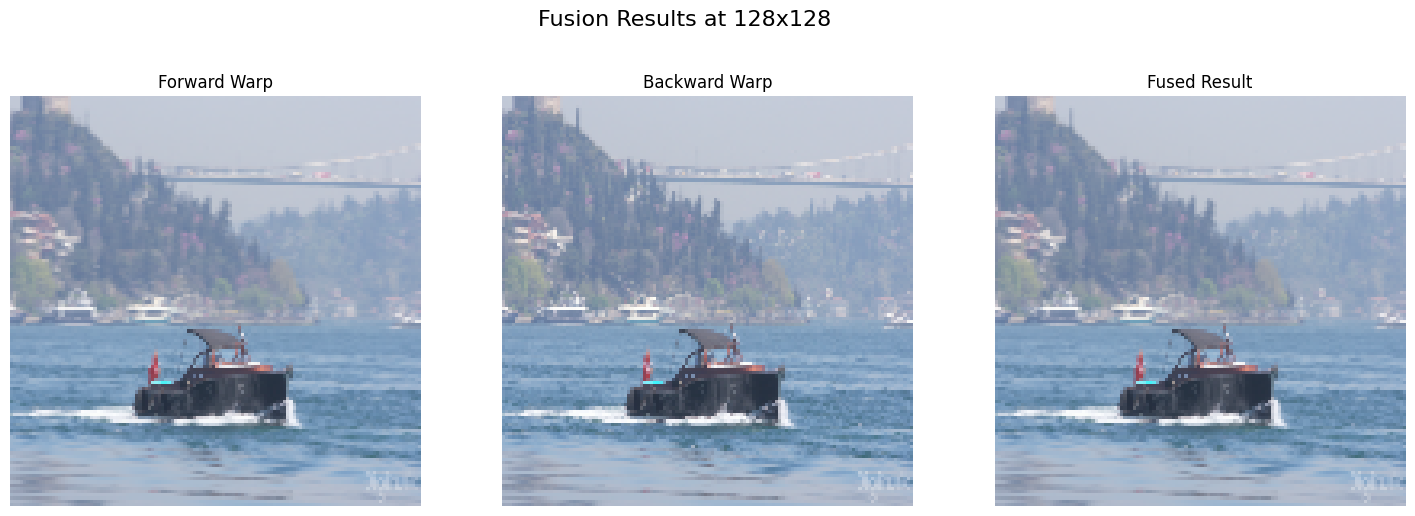

------------------------------
Processing for scale: 64x64


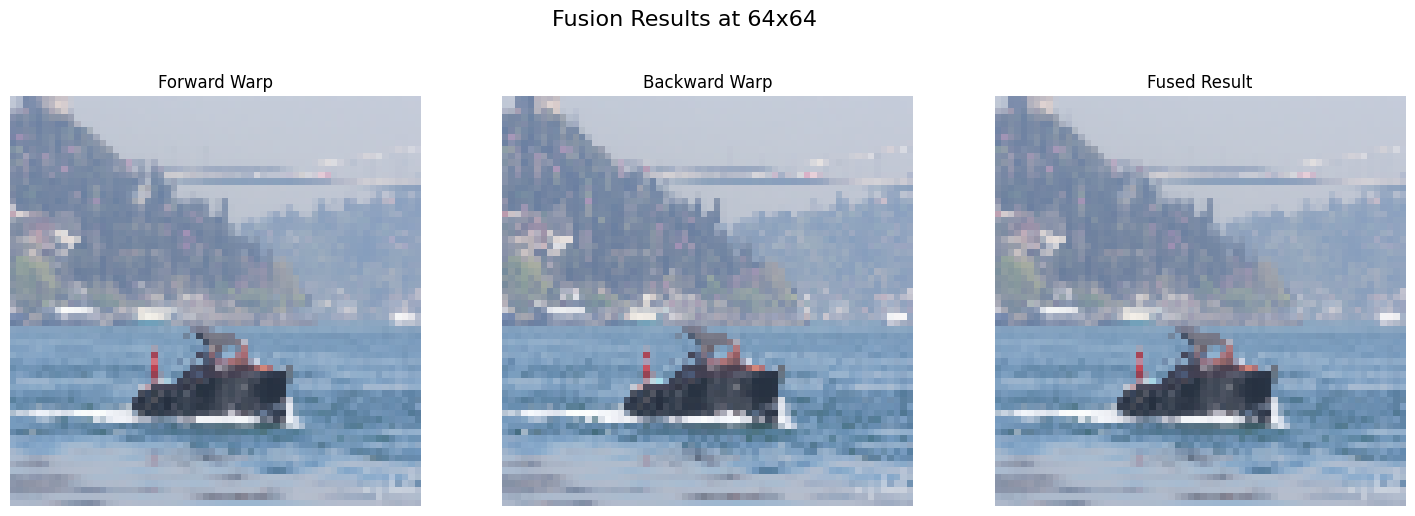

------------------------------
Processing for scale: 32x32


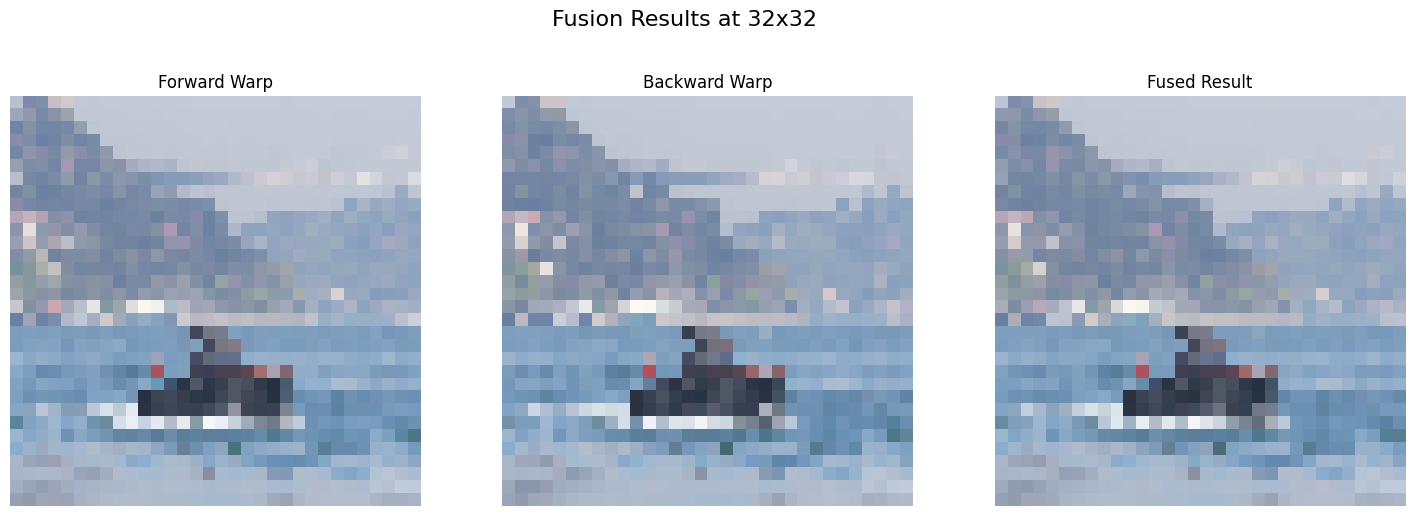

------------------------------


In [28]:
for size in target_sizes:
    print(f"Processing for scale: {size}x{size}")

    # --- Warping (Forward and Backward) ---
    img1_resized = F.interpolate(img1, size=(size, size), mode='bilinear', align_corners=False)
    img2_resized = F.interpolate(img2, size=(size, size), mode='bilinear', align_corners=False)
    
    scale_factor = float(size) / float(flow1.shape[-1])
    
    flow1_scaled = F.interpolate(flow1, size=(size, size), mode='bilinear', align_corners=False) * scale_factor
    flow2_scaled = F.interpolate(flow2, size=(size, size), mode='bilinear', align_corners=False) * scale_factor
    
    metric = torch.ones(1, 1, size, size, device=device, dtype=dtype)
    
    with torch.cuda.amp.autocast(enabled=False):
        warped_img1 = softsplat(tenIn=img1_resized, tenFlow=flow1_scaled, tenMetric=metric, strMode="soft")
        warped_img2 = softsplat(tenIn=img2_resized, tenFlow=flow2_scaled, tenMetric=metric, strMode="soft")

    # --- Fusion using Identity Masks ---
    # Create a mask of all ones, as requested
    identity_mask = torch.ones(1, 1, size, size, device=device, dtype=dtype)
    
    # Fuse the two warped images
    fused_img = soft_fuse(warped_img1, warped_img2, identity_mask, identity_mask)

    # --- 4. Display all three results ---
    display_fusion_results(
        warped_img1,
        warped_img2,
        fused_img,
        main_title=f"Fusion Results at {size}x{size}"
    )
    print("-" * 30)

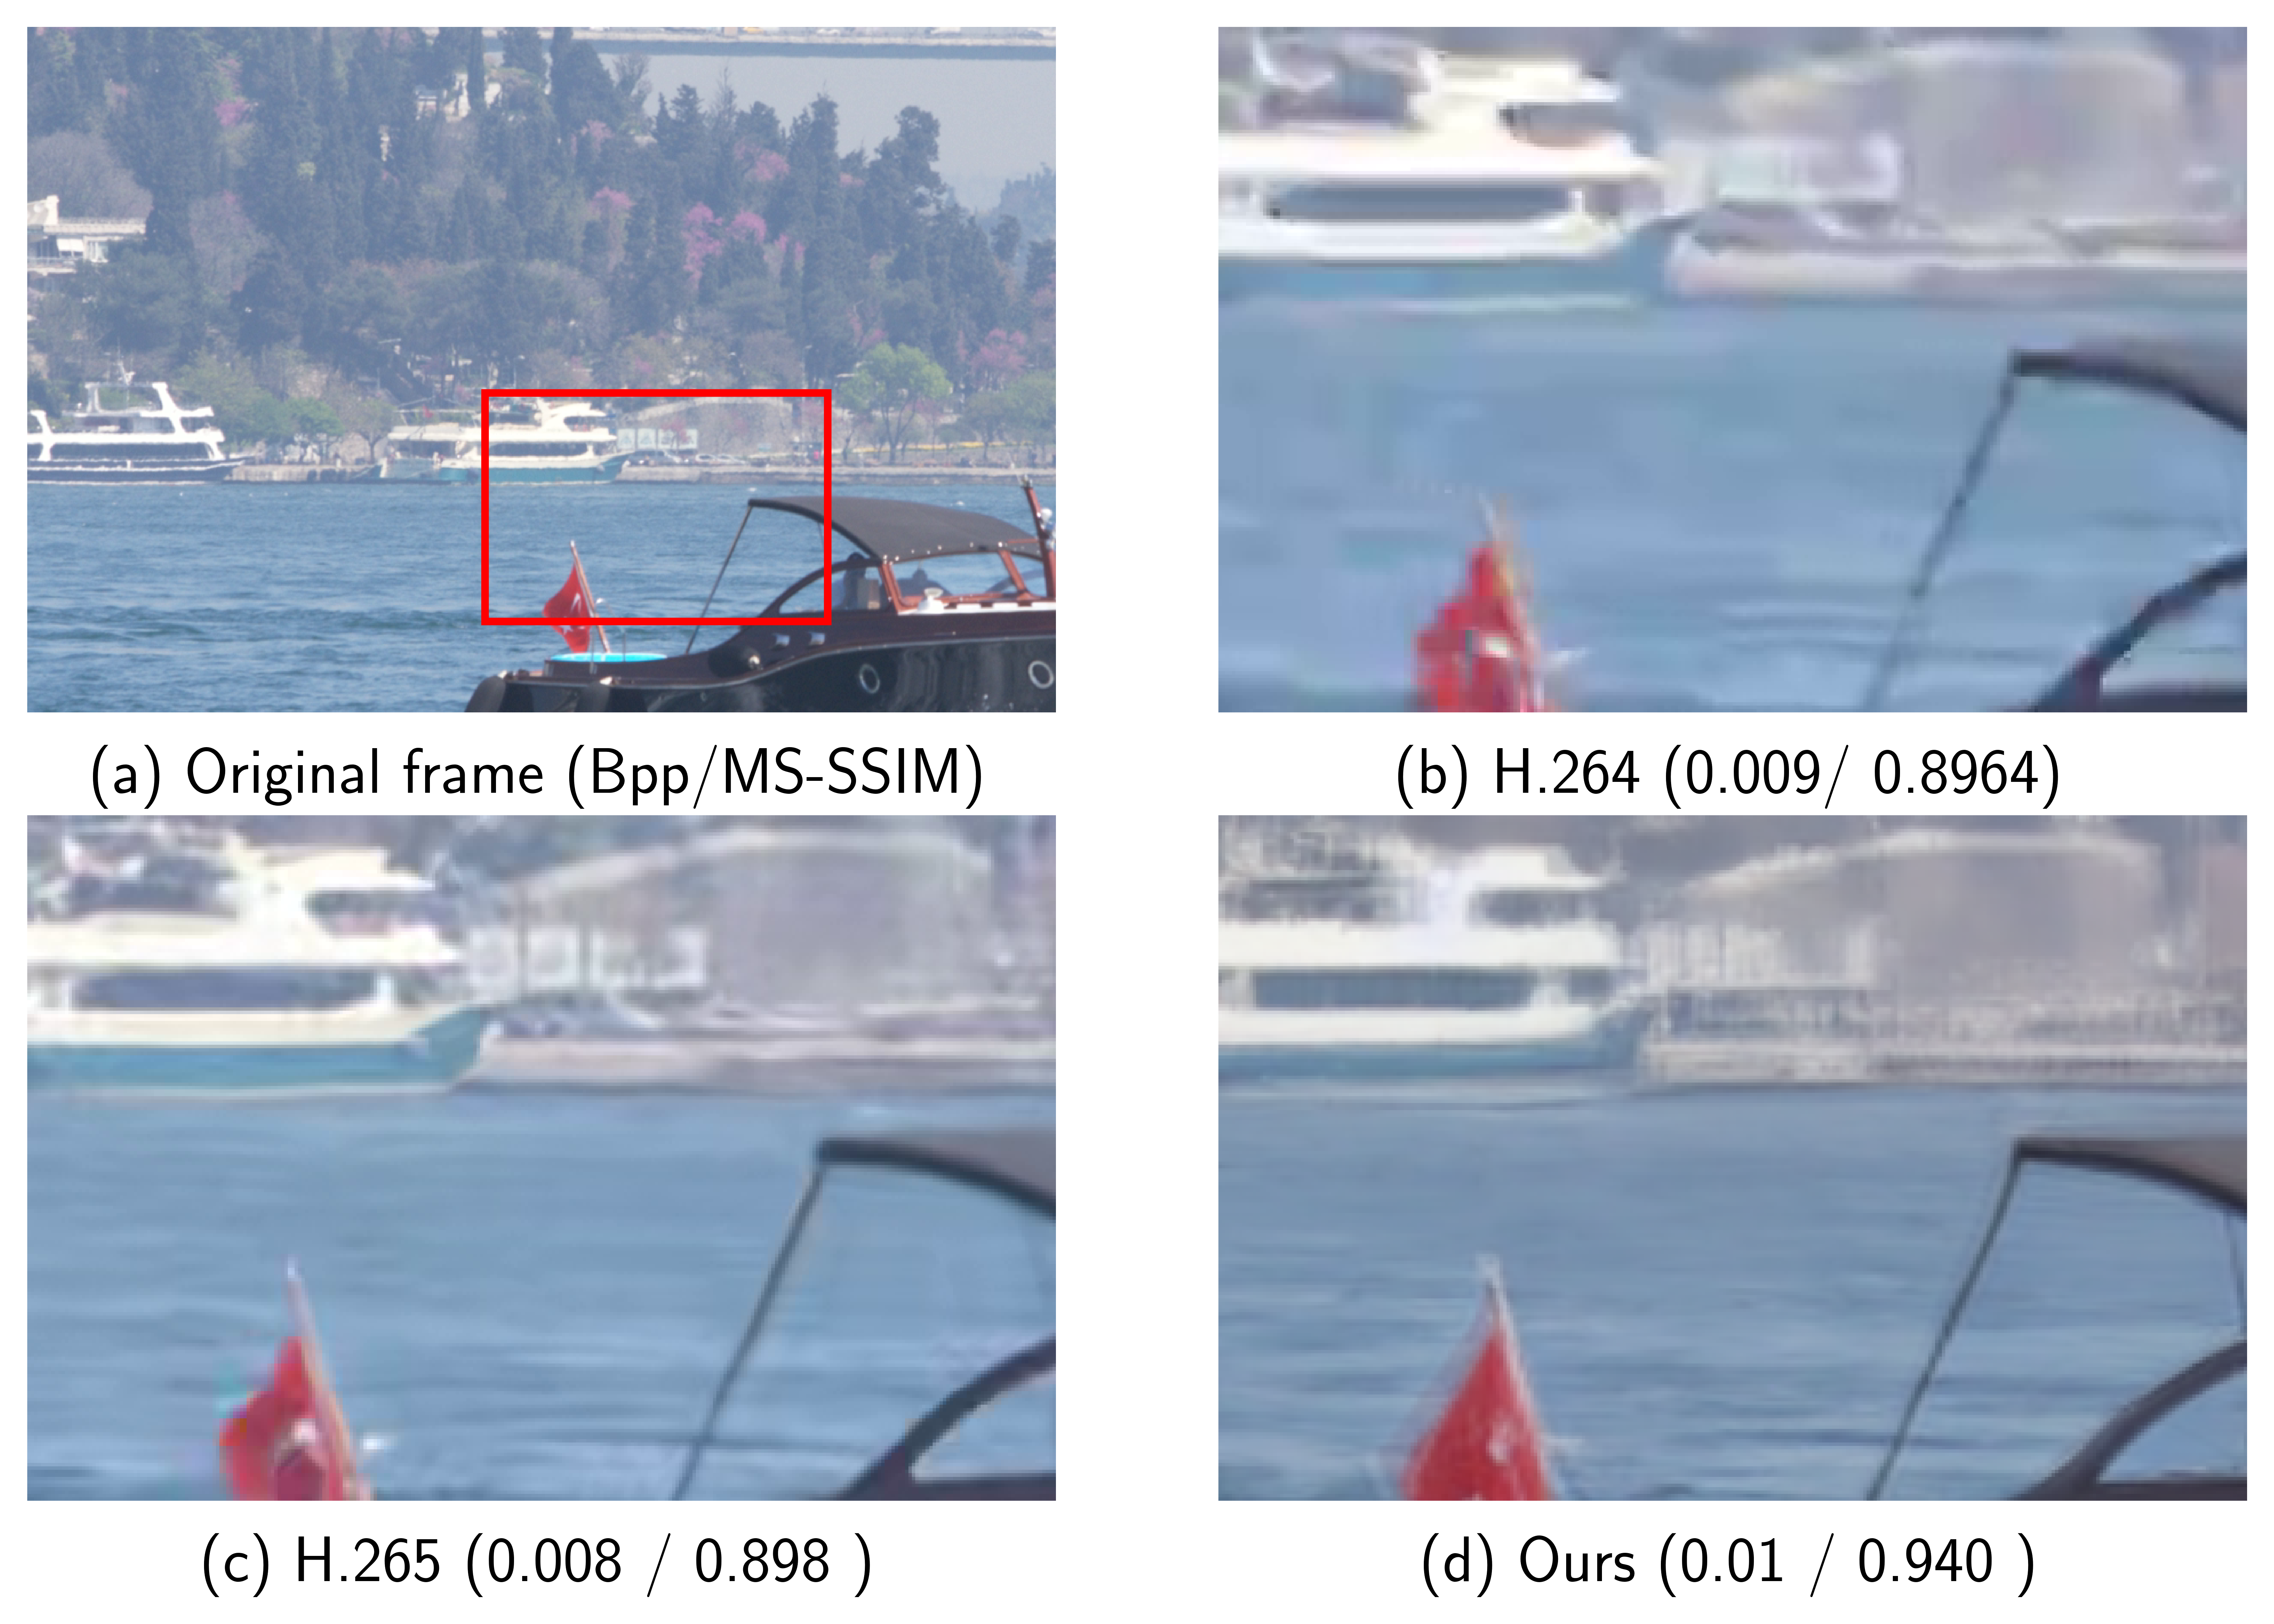

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.rcParams['text.usetex'] = True
# ----------------------------
# Paths to your 4 images
# ----------------------------
img_a = "data/Bosphorus/images/frame_0015.png"
img_b = "benchmark_results/gop8_results/h264_uvg_gop8/Bosphorus/bpp_0.01/frame_015.png"
img_c = "benchmark_results/gop8_results/hevc_uvg_gop8/Bosphorus/bpp_0.01/frame_015.png"
img_d = "benchmark_results/bosphorus_im15_ours.png"

# ----------------------------
# Load images
# ----------------------------
images = [mpimg.imread(p) for p in [img_a, img_b, img_c, img_d]]

# ----------------------------
# Define crop region (ymin:ymax, xmin:xmax)
# Adjust these values to your desired region
# Example: crop box around the ball
# ----------------------------
crop_y = (320, 520)   # vertical range
crop_x = (400, 700)   # horizontal range

def crop(img, x_range, y_range):
    return img[y_range[0]:y_range[1], x_range[0]:x_range[1]]

# Create cropped versions for the 3 compressed images
crops = [crop(img[200:800,200:1100], crop_x, crop_y) for img in images[1:]]

# ----------------------------
# Plot 4-panel figure
# ----------------------------
fig, axes = plt.subplots(2, 2, figsize=(9, 6), dpi=800)
axes = axes.flatten()

# Full original
axes[0].imshow(images[0][200:800,200:1100])
axes[0].axis('off')
axes[0].set_title("(a) Original frame (Bpp/MS-SSIM)", fontsize=17, fontfamily='Times New Roman', y=-0.15)

# Add red rectangle showing the cropped region on the full image
rect = plt.Rectangle(
    (crop_x[0], crop_y[0]),
    crop_x[1] - crop_x[0],
    crop_y[1] - crop_y[0],
    linewidth=2, edgecolor='r', facecolor='none'
)
axes[0].add_patch(rect)

# Cropped regions for other codecs
captions = [
    "(b) H.264 (0.009/ 0.8964)",
    "(c) H.265 (0.008 / 0.898 )",
    "(d) Ours (0.01 / 0.940 )"
]

for ax, crop_img, cap in zip(axes[1:], crops, captions):
    ax.imshow(crop_img)
    ax.axis('off')
    ax.set_title(cap, fontsize=17, y=-0.15)

plt.tight_layout()

# Reduce space between columns (wspace ↓)
# Increase space between rows (hspace ↑)
plt.subplots_adjust(wspace=0.01, hspace=0.15)

plt.savefig("benchmark_results/visual_quality_comparison.pdf", bbox_inches='tight', dpi=800, format='pdf')
plt.show()
